In [1]:
## Sucker tip distribution 
# Examines the distribution of nerve tips around the sucker. Nerves are tagged as originating from the internal ANC (InA) or external ANC (ExA).
# Cassady S. Olson 

import os
import sys
import imagej
import numpy as np

import matplotlib.pyplot as plt
from nerveAnalysisFunctions import getFiles, unitVector, mag2d, cent_pnt, translate

ij = imagej.init(['sc.fiji:fiji', 'org.morphonets:SNT'], mode = "headless")

from scyjava import jimport 
PointInImage = jimport('sc.fiji.snt.util.PointInImage')
Tree = jimport('sc.fiji.snt.Tree')
TreeStatistics = jimport('sc.fiji.snt.analysis.TreeStatistics')


print("loaded")

loaded


In [2]:
#Set Data Path 
mainPath = r"/Users/ragsdalelab/Documents/Segmentation_NerveAnalysis/data/Sucker"
subFolders = [r"/AT_Tran_ISOral_2", r"/AT_Tran_ESOral_2"]


In [3]:
# Get tips for each nerve and tag 
numFolders = len(subFolders)
root = []
allTips = []
label = []

for folder in range(numFolders):
    fileNames = getFiles(mainPath + subFolders[folder])
    numFiles = len(fileNames)
    thisLabel = folder * np.ones(numFiles)
    label = np.append(label, thisLabel)
    filePath = mainPath + subFolders[folder] + r'/'
    for file in range(numFiles): 
        #load tree 
        thisFile = filePath + fileNames[file]
        tree = Tree(thisFile)

        #Get root
        thisRoot = tree.getRoot()
        root_list = []
        root_list.append([thisRoot.x, thisRoot.y, thisRoot.z])
        root_list = np.asarray(root_list)

      
        # Get Tip
        tree_stats = TreeStatistics(tree)
        tips = tree_stats.getTips()
    
        tips_iterator = tips.iterator()
        tips_list = []
        while tips_iterator.hasNext():
            t = tips_iterator.next()
            tips_list.append([t.x, t.y, t.z])
    
        tips_list = np.asarray(tips_list)

        
        root.append(root_list)
        allTips.append(tips_list)



In [4]:
# Concatenate InA and ExA nerves into one array 

allTipsNP = np.concatenate( allTips, axis=0 )
allRoots = np.concatenate(root, axis = 0)

newLabel = []
numTrees = len(root)
for y in range(numTrees):
    thisTip = allTips[y]
    thisLabel = label[y]
    newLabel = np.append(newLabel, thisLabel*np.ones([1, len(thisTip)]))

In [5]:
# Set the center of the tips as the origin
center = cent_pnt(allTipsNP)
transTips = translate(allTipsNP, center)
collect = np.zeros([len(transTips), 2])
collect[:,0] = transTips[:,0]
collect[:,1] = transTips[:,2]

# Normalize tips
normTips = unitVector(collect, [])
normTips[:,0] = -1*normTips[:,0]


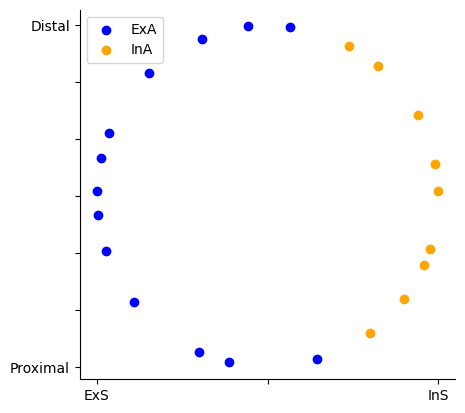

In [6]:
# Generate plot 

# Set colors for InA and ExA
cmap = ['blue', 'orange']
b = newLabel == 0
c = newLabel == 1

# Seperate tips by their label
InSTips = normTips[b,:]
ExTips = normTips[c,:]

# Plot
fig, ax = plt.subplots()
ax.scatter(ExTips[:,0], ExTips[:,1], c=cmap[0])
ax.scatter(InSTips[:,0], InSTips[:,1], c=cmap[1])

# Set plot parameters
ax.set_yticks(np.linspace(-1,1, 7))
ax.set_yticklabels(['Proximal', '','','','','','Distal'])
ax.set_xticks([-1,0,1])
ax.set_xticklabels(['ExS','', 'InS'])      
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(['ExA', 'InA'], loc="upper left") 


In [7]:
# Determine coverage by InA and ExA

# Find the bounds of InA distribution
sortTips = np.argsort(InSTips[:,0], axis = 0)
sortedTips = np.zeros([len(InSTips), 2])
sortedTips = InSTips[sortTips,:]
minTip = sortedTips[1,:]
maxTip = sortedTips[0,:]

# Find angle between bounds
x = maxTip
y = minTip
magX = mag2d(x)
magy = mag2d(y)
dotXY = np.dot(x, y)
dotMag = (dotXY)/(magX*magy)
angle = np.arccos(dotMag)
angDeg = angle * (180/np.pi)

# Convert to percentage 
angPer = angDeg/360 * 100

print('InA covers ' + str(angPer) + '% of the sucker whereas ExA covers ' + str(100- angPer) + '%')


InA covers 31.865999735601758% of the sucker whereas ExA covers 68.13400026439824%


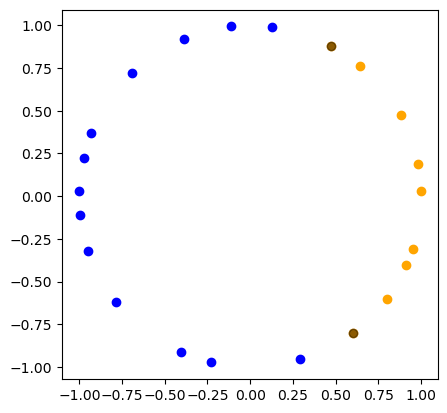

In [8]:
# Verify boundaries set above
fig, ax = plt.subplots()
ax.scatter(ExTips[:,0], ExTips[:,1], c=cmap[0])
ax.scatter(InSTips[:,0], InSTips[:,1], c=cmap[1])
ax.scatter(maxTip[0], maxTip[1], c = 'k', alpha = 0.45)
ax.scatter(minTip[0], minTip[1], c = 'k', alpha = 0.45)
ax.set_aspect(1)
